In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:

file_path = 'Data/amazon_reviews.json'
chunks = pd.read_json(file_path, lines=True, chunksize=100_000)

df_list = []
for chunk in chunks:
    df_list.append(chunk)

review_df = pd.concat(df_list, ignore_index=True)

In [2]:
print(f"Total reviews in the dataset: {len(review_df)}")

Total reviews in the dataset: 8201231


In [3]:
review_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'image',
       'style'],
      dtype='object')

## Merge With Labels Data

In [25]:
amazon_labels = pd.read_csv('Data/amazon_df_labels.csv')

In [26]:
review_labeled_df = review_df.merge(amazon_labels, on='asin')

## Distribution of Number of Reviews In Label 1 Products Versus Label 0 Products

In [29]:
matched_reviews = review_labeled_df[review_labeled_df['match'] == 1]

matched_review_counts = matched_reviews['asin'].value_counts().reset_index()
matched_review_counts.columns = ['asin', 'n_reviews']
matched_review_counts['n_reviews'].describe()

count     1444.000000
mean       130.527701
std        468.018247
min          1.000000
25%          3.000000
50%         15.000000
75%         75.250000
max      12680.000000
Name: n_reviews, dtype: float64

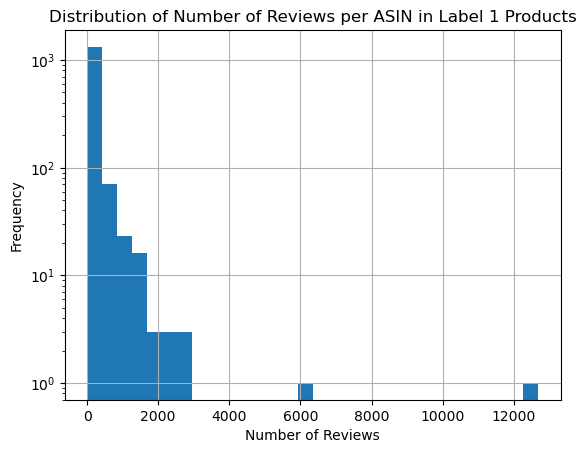

In [35]:
matched_review_counts["n_reviews"].hist(bins=30)
plt.title("Distribution of Number of Reviews per ASIN in Label 1 Products")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.yscale('log') 
plt.show()

In [36]:
nonmatched_reviews = review_labeled_df[review_labeled_df['match'] == 0]

nonmatched_review_counts = nonmatched_reviews['asin'].value_counts().reset_index()
nonmatched_review_counts.columns = ['asin', 'n_reviews']
nonmatched_review_counts['n_reviews'].describe()

count    622817.000000
mean         13.285318
std          68.427636
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max        8816.000000
Name: n_reviews, dtype: float64

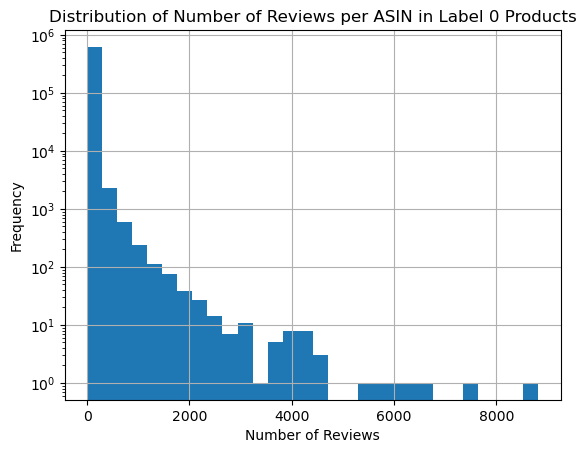

In [37]:
nonmatched_review_counts["n_reviews"].hist(bins=30)
plt.title("Distribution of Number of Reviews per ASIN in Label 0 Products")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.yscale('log') 
plt.show()

### Is there a statistically significant difference in the number of reviews between products labeled 1 and products labeled 0?

In [38]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    matched_review_counts['n_reviews'],
    nonmatched_review_counts['n_reviews'],
    equal_var=False  # Welch’s t-test
)

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 9.519073604098718
p-value: 7.055798597527428e-21


#### Interpretation of Review Count Difference

There is a **highly statistically significant difference** in the number of reviews between the two groups:

- **Matched products** (`match = 1`)
- **Non-matched products** (`match = 0`)

##### Conclusion:
We can **confidently reject the null hypothesis** that the number of reviews is the same for both groups.

---

#### Key Insight:
Products that are matched to incident reports (**match = 1**) have a **significantly different number of reviews** compared to those that are not matched (**match = 0**).

This suggests that the number of reviews may be an important factor to consider in identifying at-risk products.


In [41]:
from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(
    matched_review_counts['n_reviews'],
    nonmatched_review_counts['n_reviews'],
    alternative='two-sided'
)

print("Mann–Whitney U statistic:", u_stat)
print("p-value:", p_val)


Mann–Whitney U statistic: 678443621.0
p-value: 1.0583958074505984e-259


#### Non-Parametric Test Interpretation

This test **does not assume normality** (unlike the t-test), making it more **robust for skewed data**, which we have here.

##### Result:
Since the **p-value is effectively zero**, we have **overwhelming evidence** that:

##### The distribution of review counts is significantly different between:
- **Matched products** (`match = 1`)
- **Non-matched products** (`match = 0`)

---

##### Insight:
This result **confirms and reinforces** our earlier findings from the t-test, providing stronger confidence that **review count is associated with product risk**.


## Dropping Products with Less number of Reviews:

In [45]:
less_than_5 = len(matched_review_counts.loc[matched_review_counts['n_reviews'] < 5])
print(f"Number of matched products with fewer than 5 reviews: {less_than_5}")

less_than_4 = len(matched_review_counts.loc[matched_review_counts['n_reviews'] < 4])
print(f"Number of matched products with fewer than 4 reviews: {less_than_4}")

less_than_3 = len(matched_review_counts.loc[matched_review_counts['n_reviews'] < 3])
print(f"Number of matched products with fewer than 3 reviews: {less_than_3}")


Number of matched products with fewer than 5 reviews: 454
Number of matched products with fewer than 4 reviews: 372
Number of matched products with fewer than 3 reviews: 290


### Data Filtering Decision

Since the dataset is **highly imbalanced**, we will apply a conservative filter and **drop only products with fewer than 2 reviews**.

This helps remove extremely low-information products without significantly reducing the size of the minority class.


## Regression on Time vs. Rating

We perform a linear regression to analyze how product ratings change over time.

This helps identify trends such as:
- Increasing ratings (positive slope)
- Decreasing ratings (negative slope)
- Stable ratings (zero slope)

Understanding these trends may reveal early signals of product issues, especially when combined with incident report matches.


In [6]:
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression

def fit_model(asin, group):
    if len(group) < 2:
        return None
    X = group['unixReviewTime'].values.reshape(-1, 1)
    y = group['overall'].values
    model = LinearRegression().fit(X, y)
    return {
        'asin': asin,
        'slope': model.coef_[0],
        'intercept': model.intercept_,
        'r_squared': model.score(X, y),
        'n_reviews': len(group)
    }

# Group data
grouped = df.groupby('asin')

# Run in parallel
results = Parallel(n_jobs=-1)(  # use all CPU cores
    delayed(fit_model)(asin, group) for asin, group in grouped
)

# Remove None entries
results = [r for r in results if r is not None]
regression_results_df = pd.DataFrame(results)

In [8]:
regression_results_df.head()

,asin,slope,intercept,r_squared,n_reviews
0,0004983289,1.149971e-08,-12.383086,0.185302,5
1,0020232233,3.257850e-08,-44.413916,0.109619,23
2,0096737581,2.133470e-07,-314.907834,1.000000,3
3,0152014764,-2.069603e-09,7.841330,0.036210,13
4,0298752530,-0.000000e+00,5.000000,1.000000,3


In [12]:
regression_labeled_df = regression_results_df.merge(amazon_labels, on='asin')

In [13]:
regression_labeled_df.head()

,asin,slope,intercept,r_squared,n_reviews,match,incident_indices
0,0004983289,1.149971e-08,-12.383086,0.185302,5,0,[]
1,0020232233,3.257850e-08,-44.413916,0.109619,23,0,[]
2,0096737581,2.133470e-07,-314.907834,1.000000,3,0,[]
3,0152014764,-2.069603e-09,7.841330,0.036210,13,0,[]
4,0298752530,-0.000000e+00,5.000000,1.000000,3,0,[]


In [17]:
def classify_slope(x, epsilon=1e-7):
    if x > epsilon:
        return 'positive'
    elif x < -epsilon:
        return 'negative'
    else:
        return 'zero'

regression_labeled_df['slope_sign'] = regression_labeled_df['slope'].apply(classify_slope)

In [18]:
# Count how many positive/negative slopes exist for match=0 and match=1
slope_summary = regression_labeled_df.groupby(['match', 'slope_sign']).size().unstack(fill_value=0)
print(slope_summary)

slope_sign  negative  positive    zero
match                                 
0              17809     15193  364415
1                 37        36    1274


In [20]:
import pandas as pd
from scipy.stats import chi2_contingency

# Build the contingency table
contingency_table = pd.DataFrame({
    'negative': [17809, 37],
    'positive': [15193, 36],
    'zero':     [364415, 1274]
}, index=[0, 1])  # match = 0 and match = 1

# Run chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("p-value:", p)


Chi-squared Statistic: 14.892414281763699
Degrees of Freedom: 2
p-value: 0.0005836511258524527


## Interpretation of Chi-Square Test on Slope Signs

There is a statistically significant difference between slopes of label 0 items and label 1 items in the slope. 

There are a lot of zeros slope products. This might be due to number of reviews. Let's analyze number of reviews.

In [21]:
regression_labeled_df["n_reviews"].describe()

count    398764.000000
mean         20.633029
std          85.003597
min           2.000000
25%           2.000000
50%           5.000000
75%          13.000000
max       12680.000000
Name: n_reviews, dtype: float64

In [46]:
regression_labeled_df["match"].value_counts()

match
0    397417
1      1347
Name: count, dtype: int64